# Calibrate the angles using STO peak position

In [37]:
%matplotlib inline
import h5py
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fsolve

In [38]:
def wavelenth(energy): #energy unit: keV
    h = 4.135667662 * 10**(-18) #keV*s Planck constant
    c = 2.99792458 * 10**18 #A speed of light
    return h*c/energy
print(wavelenth(11.3001) , wavelenth(12.15))

1.0971955769082515 1.020446069022299


In [39]:
def degtoarc (deg):
    """converts degree to arcs
    deg: float
    returns: float
    """
    return deg/180*np.pi

def arctodeg (arc):
    """converts arcs to degree
    arc: float
    returns: float
    """
    return arc*180/np.pi

In [40]:
def AnglesToQ(lamda, th, zeta, delta, nu): # angles should be numpy arrays.
    #convert all degrees to arc.
    th_a = degtoarc(th)
    zeta_a = degtoarc(zeta)
    delta_a = degtoarc(delta)
    nu_a = degtoarc(nu)
    Qx = 2.0 * np.pi / lamda * (np.cos(th_a)*np.sin(delta_a)-np.sin(th_a)*((np.cos(zeta_a)*(np.cos(nu_a)*np.cos(delta_a)-1)+np.sin(zeta_a)*np.sin(nu_a)*np.cos(delta_a))))
    Qy = 2.0 * np.pi / lamda * (np.sin(th_a)*np.sin(delta_a)+np.cos(th_a)*((np.cos(zeta_a)*(np.cos(nu_a)*np.cos(delta_a)-1)+np.sin(zeta_a)*np.sin(nu_a)*np.cos(delta_a))))
    Qz = 2.0 * np.pi / lamda * (-np.sin(zeta_a)*(np.cos(nu_a)*np.cos(delta_a)-1) + np.cos(zeta_a)*np.sin(nu_a)*np.cos(delta_a)) + th * 0.0
    return Qx, Qy, Qz
lamda = wavelenth(11.3001)

In [41]:
def QTohkl(a, Qx, Qy, Qz): # a is the lattice prameter of STO
    return a / (2.0 * np.pi) * Qx, a / (2.0 * np.pi) * Qy, a /(2.0 * np.pi) * Qz #return h, k, l

In [42]:
def QToCA (Qx, Qz): ##converting Qx and Qz to a and c
    return (2.0 * np.pi)/Qx, (2.0 * np.pi)/Qz ##returns a, c

In [43]:
dtheta = (75.0*10**(-6))/(35.0*10**(-2))*180.0/np.pi # angle per pixel

In [48]:
def STOcalibration(lamda,a,x,y,zeta):
    def equations(i):
        lamda = wavelenth(11.3001)
        a = 3.9066
        th, delta, nu = i[0], i[1], i[2]
        Qx, Qy, Qz = AnglesToQ(lamda, th, zeta, delta, nu)
        h, k, l = QTohkl(a, Qx, Qy, Qz)
        return(h-1.0, k ,l-1.0)
    s = fsolve(equations,[1, 1, 1])
    for i in range(3):
        while s[i]>180.0:
            s[i] -= 360.0
        while s[i]<-180.0:
            s[i] += 360.0
    th, delta, nu = s[0], s[1], s[2]
    print(th,zeta,delta,nu)

    return th, float(x)-delta/dtheta, float(y)+nu/dtheta #return th, (x_offset, y_offset)
print(STOcalibration(lamda,3.9066,748,299,12))
zeta = 12
th, x_offset, y_offset = STOcalibration(lamda,3.9066,748,299,zeta)
def PixelsToAngles(x,y): # x and y are numpy arrays.
    return dtheta * (x - x_offset), -dtheta * (y - y_offset) #return delta, nu

4.27679469439 12 16.2646710866 16.3578962136
(4.2767946943935726, -576.73629033741327, 1631.3293555897958)
4.27679469439 12 16.2646710866 16.3578962136


In [49]:
def STOangles(a,lamda,h,k,l,th,zeta,delta,nu):
    size = 10
    
    #make one of them variable.
    th_range = np.array(range(0,size*10,1))*0.1 + th - size/2.0
    zeta_range = np.array(range(0,size*10,1))*0.1 + zeta - size/2.0
    delta_range = np.array(range(0,size*10,1))*0.1 + delta - size/2.0
    nu_range = np.array(range(0,size*10,1))*0.1 + nu - size/2.0


    #plot 
    plt.figure(num = 'hkl',figsize=(10,10))
    
    #plot hkl vs th
    Qx, Qy, Qz = AnglesToQ(lamda, th_range, zeta, delta, nu)
    h, k, l = QTohkl(a, Qx, Qy, Qz)
    plt.subplot(3,4,1)
    plt.title("th")
    plt.ylabel("h",fontsize = 15)
    plt.plot(th_range,h)
    plt.ylim(0.9,1.1)
    plt.axvline(x = th,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.subplot(3,4,5)
    plt.ylabel("k",fontsize = 15)
    plt.plot(th_range,k)
    plt.ylim(-0.1,0.1)
    plt.axvline(x = th,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 0.0,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.subplot(3,4,9)
    plt.ylabel("l",fontsize = 15)
    plt.plot(th_range,l)
    plt.ylim(0.9,1.1)
    plt.axvline(x = th,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black')
    
    #plot hkl vs zeta
    Qx, Qy, Qz = AnglesToQ(lamda, th, zeta_range, delta, nu)
    h, k, l = QTohkl(a, Qx, Qy, Qz)
    plt.subplot(3,4,2)
    plt.title("zeta")
    plt.plot(zeta_range,h)
    plt.ylim(0.9,1.1)
    plt.axvline(x = zeta,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.subplot(3,4,6)
    plt.plot(zeta_range,k)
    plt.ylim(-0.1,0.1)
    plt.axvline(x = zeta,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 0.0,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.subplot(3,4,10)
    plt.plot(zeta_range,l)
    plt.ylim(0.9,1.1)
    plt.axvline(x = zeta,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black') 
    
    #plot hkl vs delta
    Qx, Qy, Qz = AnglesToQ(lamda, th, zeta, delta_range, nu)
    h, k, l = QTohkl(a, Qx, Qy, Qz)
    plt.subplot(3,4,3)
    plt.title("delta")
    plt.plot(delta_range,h)
    plt.ylim(0.9,1.1)
    plt.axvline(x = delta,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black') 
    plt.subplot(3,4,7)
    plt.plot(delta_range,k)
    plt.ylim(-0.1,0.1)
    plt.axvline(x = delta,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 0.0,linestyle = '-.',linewidth = 0.7,color = 'black') 
    plt.subplot(3,4,11)
    plt.plot(delta_range,l)
    plt.ylim(0.9,1.1)
    plt.axvline(x = delta,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black')        
    
    #plot hkl vs nu
    Qx, Qy, Qz = AnglesToQ(lamda, th, zeta, delta, nu_range)
    h, k, l = QTohkl(a, Qx, Qy, Qz)
    plt.subplot(3,4,4)
    plt.title("nu")
    plt.plot(nu_range,h)
    plt.ylim(0.9,1.1)
    plt.axvline(x = nu,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black')        
    plt.subplot(3,4,8)
    plt.plot(nu_range,k)
    plt.ylim(-0.1,0.1)
    plt.axvline(x = nu,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 0.0,linestyle = '-.',linewidth = 0.7,color = 'black')        
    plt.subplot(3,4,12)
    plt.plot(nu_range,l)
    plt.ylim(0.9,1.1)
    plt.axvline(x = nu,linestyle = '-.',linewidth = 0.7,color = 'black')
    plt.axhline(y = 1.0,linestyle = '-.',linewidth = 0.7,color = 'black')        
    
    plt.show()

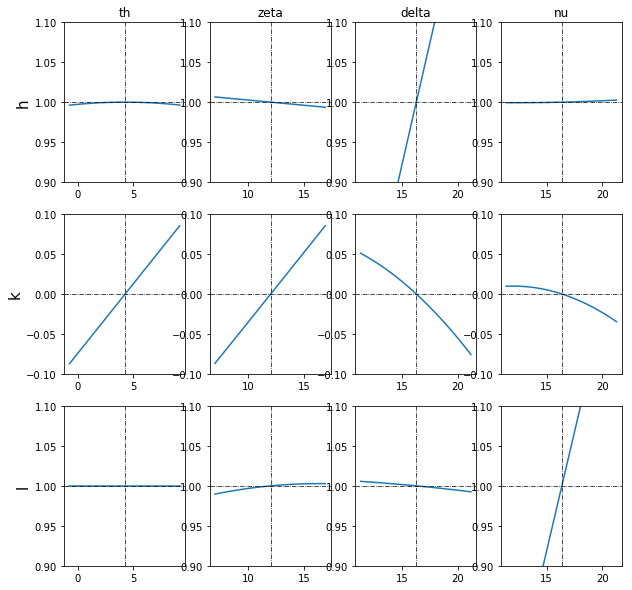

In [51]:
STOangles(3.9066,wavelenth(11.3001),1,0,1,    4.27679469439, 12, 16.2646710866, 16.3578962136) #(a,lamda,h,k,l,   th,zeta,delta,nu)

In [47]:
from prettytable import PrettyTable
T = PrettyTable(["Energy of X-ray (keV)","Temperature(C)", "a(A)", "th", "zeta", "delta", "nu"])  
T.align["City name"] = "l"# Left align city names

T.add_row([11.3001,620, 3.9251, 10.9241726, 5.21, 15.93029446, 16.52857354])
T.add_row([11.3001,30, 3.9049, 11.00891478, 5.21, 16.0101983, 16.62107027])  
T.add_row([11.3001,80, 3.9066, 11.0017483, 5.21, 16.00344396, 16.61324425])  
T.add_row([11.3001,510, 3.9213, 10.94004568, 5.21, 15.9452671, 16.54589177]) 
T.add_row([11.3001,540, 3.9223, 10.93586549, 5.21, 15.9413243, 16.54133067])
T.add_row([11.3001,570, 3.9233, 10.93168749, 5.21, 15.93738338, 16.53677219]) 
T.add_row([12.15,80, 3.9066, 9.85244047, 5.21, 14.91337496, 15.3669019]) 

print(T)

+-----------------------+----------------+--------+-------------+------+-------------+-------------+
| Energy of X-ray (keV) | Temperature(C) |  a(A)  |      th     | zeta |    delta    |      nu     |
+-----------------------+----------------+--------+-------------+------+-------------+-------------+
|        11.3001        |      620       | 3.9251 |  10.9241726 | 5.21 | 15.93029446 | 16.52857354 |
|        11.3001        |       30       | 3.9049 | 11.00891478 | 5.21 |  16.0101983 | 16.62107027 |
|        11.3001        |       80       | 3.9066 |  11.0017483 | 5.21 | 16.00344396 | 16.61324425 |
|        11.3001        |      510       | 3.9213 | 10.94004568 | 5.21 |  15.9452671 | 16.54589177 |
|        11.3001        |      540       | 3.9223 | 10.93586549 | 5.21 |  15.9413243 | 16.54133067 |
|        11.3001        |      570       | 3.9233 | 10.93168749 | 5.21 | 15.93738338 | 16.53677219 |
|         12.15         |       80       | 3.9066 |  9.85244047 | 5.21 | 14.91337496 |  15.